<h1><center> Models & Algorithms - Final Project </center></h1>
<h2><center> Parameter inference from partial observations of a Lotka-Volterra process </center></h2>
<h3><center> Charif El gataa, Romano Jérôme </center></h3>

Consider a population of two interacting species, namely predators and prey. The state of the system at each time step (we consider here a discrete time description of the dynamic) is described by the number of individuals belonging to the two categories, $N_{pred}(t)$ and $N_{prey}(t)$ for predators and prey respectively. During the dynamic three events can happen:

$(1)$ Each one of the prey can reproduce (breed) with a probability $\lambda_{breed}$;

$(2)$ A predator can kill one of the prey and reproduce with a probability $\lambda_{interaction}$;

$(3)$ A predator dies with probability $\lambda_{death}$.


The Lotka-Volterra model is the simplest model of predator-prey interactions. It was developed independently by:
 
- Alfred Lotka, an American biophysicist (1925)
- Vito Volterra, an Italian mathematician (1926).

The underlined idea of the model is that the population change of one species depends on:

1) Its current population.

2) Its reproduction rate.

3) Its interactions with other species (predation or prey)

In the deterministic model, the dynamics of the two populations are described by a system of coupled differential equations:

\begin{equation*}
\begin{cases}
\frac{dx}{dt} = Ax - Bxy   \ \ \ \ \ \ \text{"prey equation"}\\ 
\frac{dy}{dt} = -Cy + Dxy  \ \ \ \ \ \ \text{"predator equation"}\\ 
\end{cases}
\end{equation*}

where $x$ represents the prey population, and $y$ represents the predator population.

The parameters are:
- $A$: natural reproduction rate of prey in the absence of predation.
- $B$: death rate per encounter of prey due to predation.
- $C$: natural death rate of predators in the absence of food (prey).
- $D$: reproduction of predators by eating the prey.

So, in our case $D$=$B$, and we can rewrite the model as follow:

\begin{equation*}
\begin{cases}
\frac{dx}{dt} = Ax - Bxy\\ 
\frac{dy}{dt} = -Cy + Bxy\\ 
\end{cases}
\end{equation*}

Therefore, the model assumes that the prey species grows exponentially in the absence of predation, and that the predator species starves in the absence of prey; in addition, the predator species can reproduce by eating the prey.

The model provides a simple but powerful framework to understand the complex interactions between two species in an ecosystem and has been widely used in biology to study the dynamics of predator-prey relationships, as well as in other fields such as economics, epidemiology, and chemistry.

The stochastic predator-prey process can be described by the following rate reazioni:
\begin{align*}
a + X \quad \rightarrow \quad 2X \ \ \ \ \ \ \ \text{with rate $\lambda_{breed}$}  \\
X + Y \quad \rightarrow \quad 2Y \ \ \ \ \ \ \ \text{with rate $\lambda_{interaction}$} \\
Y \quad \rightarrow \quad 0 \ \ \ \ \ \ \ \text{with rate $\lambda_{death}$} 
\end{align*}

where $X$ denotes the prey population, $Y$ is the predator population and "$a$" is the fixed amount of resource available to the prey, that we assume equal to $0$.


### Questions :

## A) Simulate a dynamical system 

Simulate a dynamical system of this type using a population-based implementation. Study the behavior of the dynamical system when changing the values of parameters ($\lambda_{breed}$, $\lambda_{interaction}$, $\lambda_{death}$) and identify an interesting regime, i.e. the two species do not face extinction after a few steps of the simulation.

In [1]:
# Now we say to Julia to use all these packages inside our code 
using Plots, Statistics
using Printf
using ProgressMeter
using Distributions
using StatsPlots
using StatsBase
using MCMCDiagnosticTools
using Random

Random.seed!(123) 

TaskLocalRNG()

Let's start by analyzing the number of preys only. From an individual-based point of view, each prey in the system can die, reproduce or survive only, in each point in time. A prey can both reproduce and die in a same instant (meaning that she can reproduce and be killed right after). Therefore, there are 3 events $E$: die (D), reproduce (R), and survive (S); these events are non-mutually exclusive, with the exception of D and S.\
To compute the conditional probability of dying for a prey, consider that there are only two events with non zero probability:

\begin{equation*}
A = \text{prey } i \text{ is killed by 1 predator} \qquad B = \text{prey } i \text{ is killed by 0 predators} 
\end{equation*}

Indeed, the events of a prey being eaten by more than 1 predator has zero probability. It follows that

\begin{equation*}
P(A) + P(B) = 1
\end{equation*}

The probability of being eaten by 0 predators is given by the intersection of the independent events of surviving all predators, $(1-\lambda_{interaction})^{N_{pred}}$. Therefore,

\begin{equation*}
\begin{split}
P(E_i^t =D) = P(A) &= 1 - P(B) \\
&= 1 - (1-\lambda_{interaction})^{N_{pred}}
\end{split}
\end{equation*}

To summarize, the conditional probabilities faced by each prey $i$ are:

\begin{align*}
P(E_i^t=D | E_i^{t-1}) &= \mathbb{1}[E_i^{t-1}=S][1 - (1-\lambda_{interaction})^{N_{pred}}] \\
P(E_i^t=R | E_i^{t-1}) &= \mathbb{1}[E_i^{t-1}=S]\lambda_{breed} \\
P(E_i^t=S | E_i^{t-1}) &= \mathbb{1}[E_i^{t-1}=S](1-\lambda_{interaction})^{N_{pred}}
\end{align*}

Talking about the population of preys, its evolution can be described by the number of prey died, $N_{D_{prey}}$, and the number of preys reproduced, $N_{R_{prey}}$. In particular, in each period it holds that 

\begin{equation*}
N_{prey}^t = N_{prey}^{t-1}-N_{D_{prey}}^t+N_{R_{prey}}^t
\end{equation*}

Therefore, in order to describe the evolution of $N_{prey}$, we should first derive the probabilities generating $N_{D_{prey}}, N_{R_{prey}}$. These are given by the Binomial distribution where each Bernoullian extraction has the individual conditional probability described above,

\begin{align*}
P(N_{D_{prey}}^t | N_{prey}^{t-1}) &=\binom{N_{prey}^{t-1}}{N_D^t} [1 - (1-\lambda_{interaction})^{N_{pred}}]^{N_{D_{prey}}^t} [(1-\lambda_{interaction})^{N_{pred}}]^{N_{prey}^{t-1}-N_{D_{prey}}^t} \\
P(N_{R_{prey}}^t | N_{prey}^{t-1}) &=\binom{N_{prey}^{t-1}}{N_R^t} (\lambda_{breed})^{N_{R_{prey}}^t}(1-\lambda_{breed})^{N_{prey}^{t-1}-N_{R_{prey}}^t} 
\end{align*}



Similarly, a predator $j$ can die, reproduce or just survive. We are interested in the evolution of the population of predators, which is given by

\begin{equation*}
N_{pred}^t = N_{pred}^{t-1}-N_{D_{pred}}^t+N_{R_{pred}}^t
\end{equation*}

where $N_{D_{pred}}^t, N_{R_{pred}}^t$ are the number of predators died and reproduced in $t$ respectively. We know that in our model 

\begin{equation*}
N^t_{D_{prey}} = N^t_{R_{pred}}
\end{equation*}

Therefore, we just need to derive the probability distribution for $N_{D_{pred}}^t$, that is: 

\begin{equation*}
P(N_{D_{pred}}^t | N_{pred}^{t-1}) =\binom{N_{pred}^{t-1}}{N_{D_{pred}}^t} (\lambda_{death})^{N_{D_{pred}}^t}(1-\lambda_{death})^{N_{pred}^{t-1}-N_{D_{pred}}^t} 
\end{equation*}

In the following, we propose a function for generating the realizations of $N_{prey}^t, N_{pred}^t$ in each point in time, given the initial number of preys and predators, and the probabilities $\lambda_{breed},\lambda_{death},\lambda_{interaction}$ describing the model. 

Then, we use this function to generate many possible regimes and find a stationary one where cohabitation of preys and predators is observed.

In [2]:
# function to generate a realization of the discrete-time Lotka-Volterra model: population based implementation
function lv_gen(prey0::Int, pred0::Int, λ_breed::Float64, λ_interaction::Float64, λ_death::Float64, max_time::Int)
    
    # set the initial condition of the two populations
    t = 0
    n_prey = [prey0] # initialize the prey population array with the initial population size
    n_pred = [pred0] # initialize the predator population array with the initial population size

    while t < max_time - 1
        
        t += 1 # increase time step by 1
        
        # check if both prey and predator populations are non-zero
        if(n_prey[t] > 0 && n_pred[t] > 0)
            
            prey_reproduced = rand(Binomial(n_prey[t],λ_breed)) # extract a realization of the number of prey reproduced
            predator_died = rand(Binomial(n_pred[t],λ_death))   
            predator_reproduced = rand(Binomial(n_prey[t], 1-(1-λ_interaction)^n_pred[t]))
            
            # update the prey and predator populations using the formulas from the Lotka-Volterra model
            push!(n_prey, n_prey[t] + prey_reproduced - predator_reproduced)
            push!(n_pred, n_pred[t] - predator_died + predator_reproduced)
            
        # Check if there are preys but no predators
        elseif(n_prey[t]>0 && n_pred[t]==0)
            
            prey_reproduced = rand(Binomial(n_prey[t],λ_breed))           
            
            # Add the new preys and update the number of predators
            push!(n_prey,n_prey[t]+prey_reproduced)
            push!(n_pred,0)
        
                # If the predator population is greater than 0 but prey population is 0, 
        # then the predators will die as there is no prey available for them to consume.
        # The following block of code updates the predator and prey populations.
        # The new predator population will be the original predator population minus the 
        # number of predators that died due to lack of prey (aux_d). The new prey population 
        # will be 0 because there are no prey available.
        # The new prey reproduction and predator reproduction values will be 0.
        elseif(n_pred[t]>0 && n_prey[t]==0)
            
            predator_died = rand(Binomial(n_pred[t],λ_death))
            
            push!(n_pred,n_pred[t]-predator_died)
            push!(n_prey,0)
    
        # If both the predator and prey populations are 0, then there is no interaction possible 
        # between the two populations, so both the predator and prey populations remain 0.
        # The new prey reproduction and predator reproduction values will be 0.
        elseif(n_pred[t]==0 && n_prey[t]==0)
            push!(n_pred,0)
            push!(n_prey,0)
    # The function returns the updated predator and prey population values.
        end
    end
    return(n_prey=n_prey,n_pred=n_pred)
end

lv_gen (generic function with 1 method)

### Some regimes

### A.1) Extinction case - prey extinct before predators

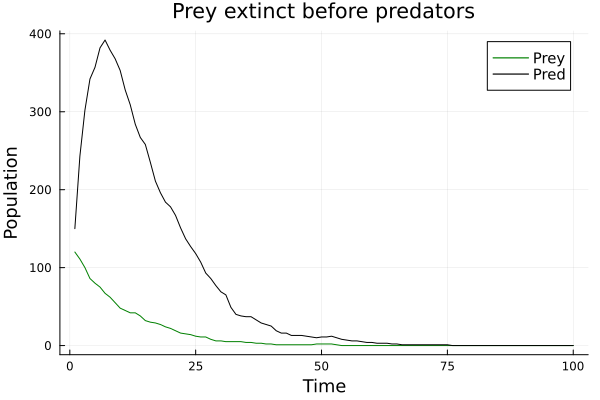

In [3]:
# Set initial values for prey and predator populations, breeding rate, interaction rate, death rate, and simulation time
prey0=120
pred0=150
λ_breed = 0.9
λ_interaction = 0.2
λ_death = 0.2
max_time = 100

# Create empty arrays to store the population values of prey and predator
Prey_all = []
Pred_all = []

# Run the simulation using the lv_gen function and store the results in the Prey_all and Pred_all arrays
res = lv_gen(prey0, pred0, λ_breed, λ_interaction, λ_death, max_time)
push!(Prey_all, res.n_prey)
push!(Pred_all, res.n_pred)

# Create a line plot of the prey and predator population values over time
plot1 = plot(res.n_prey, color=:green, label="Prey", xlabel="Time", ylabel="Population", title="Prey extinct before predators", legend=:best, size=(600,400), legendfontsize=10, guidefontsize=12)
plot1 = plot!(res.n_pred, color=:black, label="Pred")
plot(plot1)

### A.2) Prey and predators cohabitate, but predators dominate

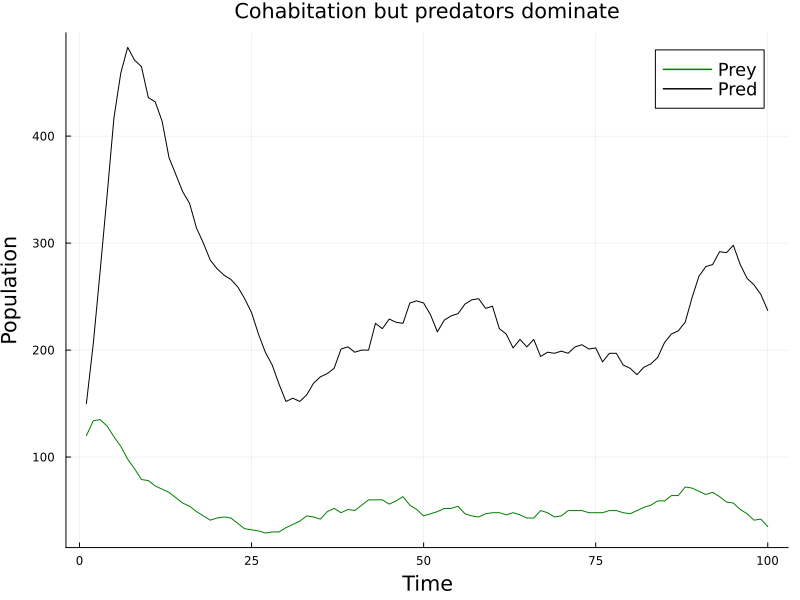

In [4]:
# Set initial values for prey and predator populations, breeding rate, interaction rate, death rate, and simulation time
prey0=120
pred0=150
λ_breed = 0.9
λ_interaction = 0.01
λ_death = 0.2
max_time = 100

# Create empty arrays to store the population values of prey and predator
Prey_all = []
Pred_all = []

# Run the simulation using the lv_gen function and store the results in the Prey_all and Pred_all arrays
res = lv_gen(prey0, pred0, λ_breed, λ_interaction, λ_death, max_time)
push!(Prey_all, res.n_prey)
push!(Pred_all, res.n_pred)

# Create a line plot of the prey and predator population values over time
plot1 = plot(res.n_prey, color=:green, label="Prey", xlabel="Time", ylabel="Population", title="Cohabitation but predators dominate", legend=:best, size=(800,600), legendfontsize=12, guidefontsize=14)
plot1 = plot!(res.n_pred, color=:black, label="Pred")
plot(plot1)

### A.3) Prey and predators cohabitate 

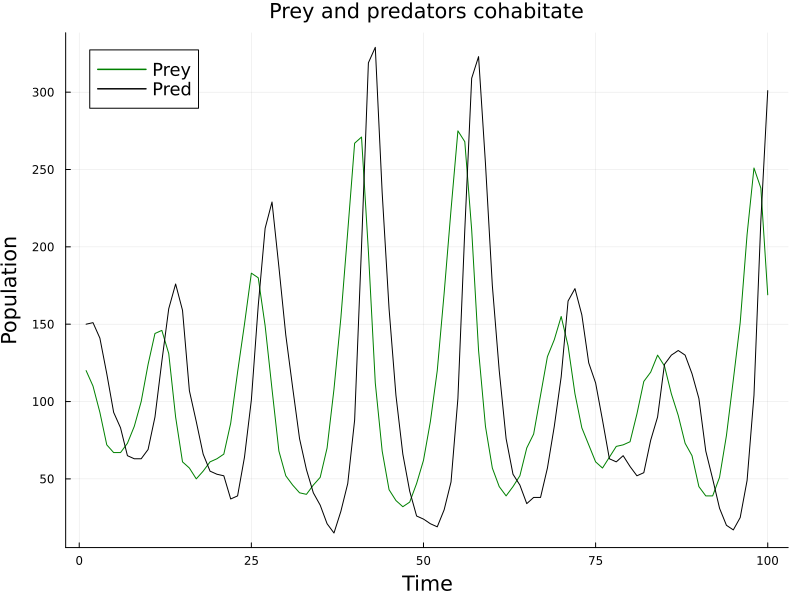

In [5]:
prey0=120
pred0=150
λ_breed=0.6
λ_interaction=0.01
λ_death=0.6
max_time= 100

# Create empty arrays to store the population values of prey and predator
Prey_all = []
Pred_all = []

# Run the simulation using the lv_gen function and store the results in the Prey_all and Pred_all arrays
res = lv_gen(prey0, pred0, λ_breed, λ_interaction, λ_death, max_time)
push!(Prey_all, res.n_prey)
push!(Pred_all, res.n_pred)

# Create a line plot of the prey and predator population values over time
plot1 = plot(res.n_prey, color=:green, label="Prey", xlabel="Time", ylabel="Population", title="Prey and predators cohabitate", legend=:best, size=(800,600), legendfontsize=12, guidefontsize=14)
plot1 = plot!(res.n_pred, color=:black, label="Pred")
plot(plot1)

We chose the last one to be our regime of interest. Therefore in the follwoing we use

\begin{equation*}
\lambda_{breed}=0.6 \quad \lambda_{death}=0.6 \quad \lambda_{interaction}=0.01
\end{equation*}

In the following we plot the number of predators against the number of preys in this regime. The circularity of the line is a graphical consequence of the stationarity of the system.

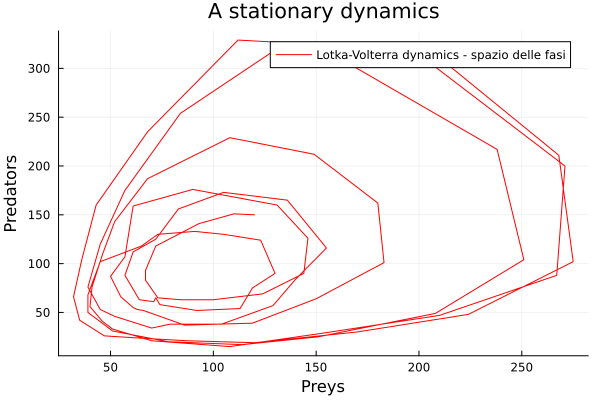

In [6]:
plot4 = plot(res.n_prey,res.n_pred,color=:red,label=:"Lotka-Volterra dynamics - spazio delle fasi",xlab=:"Preys",ylab=:"Predators", title="A stationary dynamics")
plot(plot4, legend=:best) #orbita del modello stocastico che equivale al grafico precedente

## B) Collect observations over $\Delta T$

In [7]:
prey0=120
pred0=150
λ_breed=0.6
λ_interaction=0.01
λ_death=0.6
max_time= 100

100

Using the stationary regime we identified in the previous point, we collect observations on the number of new preys and predators over a certain time period, that we define to be $t\in[25,85]$. The probability of observing the newborns is set to be $p_{obs}=0.3$. The sample collected will be later used to perform inference on the value of the probabilities governing the model. \
We define a new function for performing the sampling.

In [8]:
#we create a new structure, it works as class 
#Structs are a great way to represent data in a compact and easy-to-understand way
#By default, structs cannot be modified once initialized (i.e. are inmutable unless explicitly defined)
#here we build up a structure collecting observations about the simulation
#creiamo una struttura che raccoglie piu vettori su cui faremo girare le nostre simulazioni 100 tempi
struct Sim{T}
    n_prey::Vector{T}     # prey population over time
    n_pred::Vector{T}     # predator population over time
    n_preynew::Vector{T}  # new prey population each time step
    n_prednew::Vector{T}  # new predator population each time step
    obs_prey::Vector{T}   # observed prey population at specified times
    obs_pred::Vector{T}   # observed predator population at specified times
    
    # here we initialize the structure
    
    function Sim(T::Int) #corrisponde al numero di iterazioni della simulazioni
        return new{Int}(zeros(Int, T), zeros(Int, T), zeros(Int, T), zeros(Int, T), zeros(Int, T),zeros(Int, T))
    end
end

In [9]:

#here we introduce the feature of p_obs inside our "lv_gen" function defined previously
function lv_gen_and_obs!(res::Sim, prey0::Int, pred0::Int, λ_breed::Float64, λ_interaction::Float64, λ_death::Float64, max_time::Int, p_obs::Float64, d_start::Int, d_end::Int)
    
    # Set initial conditions
    t = 1
    n_prey = prey0
    n_pred = pred0
    res.n_prey[1] = prey0        # Set the initial number of preys
    res.n_pred[1] = pred0        # Set the initial number of predators
    res.n_preynew[1] = prey0         # Initialize the number of new preys at time t
    res.n_prednew[1] = pred0         # Initialize the number of new predators at time t
    
    # Run the simulation
    while t < max_time 
        t+=1
        
        # Generate the new population size based on breeding, interaction and death rates
        new_prey=rand(Binomial(n_prey,λ_breed))
        d_pred=rand(Binomial(n_pred,λ_death))
        new_pred = rand(Binomial(n_prey, 1-(1-λ_interaction)^n_pred))
        
        # Update the population sizes by accounting for the new populations and deaths
        prey = n_prey + new_prey - new_pred
        n_prey = max(0,prey)
        pred = n_pred + new_pred - d_pred
        n_pred = max(0,pred)
        
        # Get the observed population size, if observation window is active
        if(t >= d_start && t <= d_end)
            res.obs_prey[t] = rand(Binomial(new_prey,p_obs))     # Observed number of prey
            res.obs_pred[t] = rand(Binomial(new_pred,p_obs))     # Observed number of predators
        end
        
        # Append the population sizes to the result struct
        res.n_prey[t] = n_prey
        res.n_pred[t] = n_pred
        res.n_preynew[t] = new_prey
        res.n_prednew[t] = new_pred
    end
end

lv_gen_and_obs! (generic function with 1 method)

In [10]:
# Create an instance of the Sim struct with the specified maximum time
res = Sim(max_time)

# Define the observation parameters
p_obs = 0.3
d_start = 25
d_end = 85

# Generate data by simulating the Lotka-Volterra model and recording the observed population sizes
# The arguments to the function are:
#   - res: The Sim struct to store the simulation results
#   - prey0: The initial number of prey
#   - pred0: The initial number of predators
#   - λ_breed: The breeding rate of the prey
#   - λ_interaction: The probability that a predator catches a prey
#   - λ_death: The death rate of the predators
#   - max_time: The maximum number of time steps to simulate
#   - p_obs: The probability of observing a population size at each time step, remember that is 0.3 !
#   - d_start: The time step at which to start observing populations
#   - d_end: The time step at which to stop observing populations
lv_gen_and_obs!(res, prey0, pred0, λ_breed, λ_interaction, λ_death, max_time, p_obs, d_start, d_end)

# Store the observed prey and predator populations
obs0_prey = res.obs_prey
obs0_pred = res.obs_pred

100-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

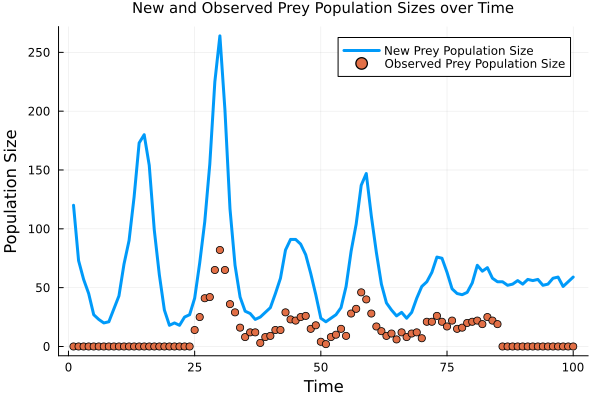

In [11]:
plot2 = plot(res.n_preynew, label="New Prey Population Size", linewidth=3.0,
             xlabel="Time", ylabel="Population Size")
scatter!(obs0_prey, label="Observed Prey Population Size", linewidth=2.0)
title!("New and Observed Prey Population Sizes over Time",titlefont=font(10))
plot!(legend=:best)


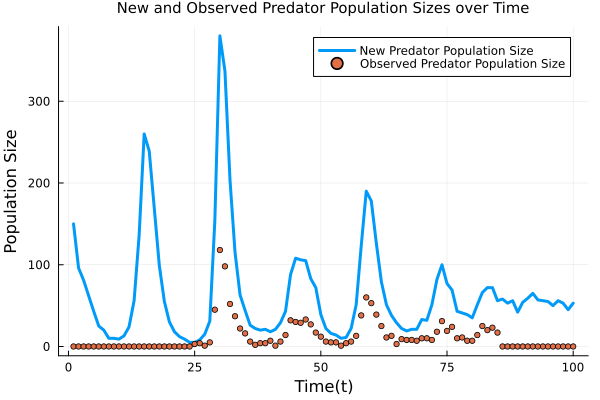

In [12]:
plot3 = plot(res.n_prednew, label="New Predator Population Size", linewidth=3.0, xlabel="Time(t)", ylabel="Population Size")
scatter!(plot3, obs0_pred, label="Observed Predator Population Size", markersize=3.0)
title!("New and Observed Predator Population Sizes over Time",titlefont=font(10))
plot!(plot3, legend=:best)

## C) Approximate Bayesian Computation Monte Carlo method to infer 2 probabilities

Now we use the sample collected in the previous point to design a ABCMC method in order to infer 2 of the three probabilities generating the data. We decide to infer $\lambda_{death}, \lambda_{breed}$, while $\lambda_{interaction}$ is set equal to its true value. Let $\theta \equiv (\lambda_{death}, \lambda_{breed})$ be the vector of the unknown parameters.

Therefore, the goal is that of finding the posterior distribution $p(\theta | D)$, i.e.: the probability distribution for the unknown parameters, given the data.

The ABCMC method reaches this goal by taking advantage of the Bayes theorem and some prior knowledge on the distribution of $\theta$. Indeed, by Bayes theorem

\begin{equation*}
p(\theta | D)= \frac{p(D | \theta)p(\theta)}{p(D)}
\end{equation*}

where $p(D | \theta)$ is the likelihood function of the observations given $\theta$, $p(\theta)$ is the assumed prior distribution, and $p(D)$ is a constant which can be safely ignored.

Therefore, we are interested in computing the estimator $\hat{\theta}_{MAP}$, that is

\begin{equation*}
\hat{\theta}_{MAP} = argmax_{\theta \in \Theta} p(\theta | D)
\end{equation*}

There are various ways for exploring the parameter space of $\hat{\theta}_{MAP}$ and estimate it. 



confrontiamo i valori osservati con quelli simulati attraverso la distanza
rej base : si definisce la distanza tra i due data set, la distanza varia e si definisce un livello di tollereanza (threshols)
generiamo osservazioni randomiche atraverso una prior
e dopo simuliamo con questi parametri un numero di coppie dei parametri ricercati
e se la distanza è piu piccola di questo epsilon li mettiamo all'interno dei due vettori e otteniamo una marginhalist
li si concentrano le osservazioni accettate


prime problematiche (hit map a buchi) : ACCETTAZIONI molto basse (viste anche dalla hit map); prior diversa dalla posterior (che cerchiamo di stimare) o epsilon molto basso 

come ovviare ? Soft Margin (livello di tolleranza debole) oltre alla soglia di accettazione epsilon, i valori simulati oltre il threshold ma sotto questa soglia vengono salvati e li attruibiremo un peso maggiore a quelli piu vicini alla soglia



### C.1) Rejection-based ABC

One approach is to use a rejection-based ABC method, which works by simulating parameter values from a prior distribution, and then accepting or rejecting those parameter values based on how closely they match the observed data. This is done by defining a distance function, that works as a discrepancy measure and quantifies how different the simulated data is from the observed ones. If the discrepancy measure is below a chosen tolerance, the parameter value is accepted; otherwise, it is rejected.
In order to compute this distance, it is possible to use summary statistics that capture important features of the data, such as the mean, variance, or autocorrelation.

More precisely, we proceed by first assuming a flat prior, i.e. $\lambda_{death}, \lambda_{breed} \in U[0,1]$. We use this flat prior to generate $p(\theta | D)$ and get some informations to construct a more precise prior distribution later. We set set $\epsilon=7$ and we proceed as follows:

1. We sample proposal parameters $l_{death}, l_{breed}$ from $U[0,1]$
2. Given $\lambda_{interaction}$, we use  $l_{death}, l_{breed}$ to generate data on $N_{prey}, N_{pred}$ from the model.
3. We sample the generated data with $p_{obs}=0.3$. Let the observations be denoted by $obs_1$ (as opposed to $obs_0$ denoting the observations from the real data collected in point b) of the project).
4. We check that $dist(obs_1, obs_0) < \epsilon$ using a Manhattan distance, and we count as 1 the case in which the condition is satisfied. 
5. if the condition of point 4) is satisfied, we store the values of $l_{breed},l_{death}$
6. Repeat step 1-5 $100000$ times.

Then we repeat the same process with a different $\epsilon$.

By looking at the stored values for $l_{breed},l_{death}$, we gain some insights into the $p(\theta | D)$. Therefore, we can now set a prior distribution, by changing minimum and maximum values of the parameters. \
We repeat steps 2-6 by sampling proposal parameters $l_{breed}, l_{death}$ from $U[\lambda_{{breed}_{min}},\lambda_{{breed}_{max}}], U[\lambda_{{death}_{min}},\lambda_{{death}_{max}}]$ respectively.

Finally, we repeat the process using the same a priori distribution, but this time, insead of throwing away parameters which don't comply with the condition in point 4), we compute for each paramter the following weight:

\begin{equation}
weight(l_{death}, l_{breed}) = exp\{-\beta[dist(obs_1(l_{death}, l_{breed}), obs_0)]\}
\end{equation}

So that we assign a greater weight to parameters generating observations nearer to the true ones. This last approach is called $\textit{soft-margin}$.


In [13]:
# This function calculates the Manhattan distance (taxicab geometry) between two vectors a and b.
function dist(a,b)
    return sum(abs.(a-b))/length(a)
end

# This function generates simulated data for prey and predator populations and compares them to observed data.
# It returns the number of simulations that match the observed data within a specified error tolerance (ϵ) and the average distance between observed and simulated data.
function gen_samples!(res, prey0, pred0, λ_breed, λ_interaction, λ_death, max_time, p_obs, d_start, d_end, numiter, obs0_prey, obs0_pred, ϵ)
    count = 0
    dist_now = 0.0
    for iter = 1:numiter
        # Generate simulated data and compare it to observed data
        lv_gen_and_obs!(res, prey0, pred0, λ_breed, λ_interaction, λ_death, max_time, p_obs, d_start, d_end);
        obs1_prey = res.obs_prey
        obs1_pred = res.obs_pred
        dist_now += dist(obs1_prey, obs0_prey) + dist(obs1_pred, obs0_pred)
        # If the simulated data matches the observed data within the specified error tolerance, increment the count
        if(dist(obs1_prey, obs0_prey) + dist(obs1_pred, obs0_pred) <= 2ϵ) # or, both smaller than ϵ
            count += 1
        end
    end
    # Calculate the average distance between observed and simulated data
    return count, dist_now/numiter 
end

gen_samples! (generic function with 1 method)

### C.1.1) A flat prior

In [14]:
# Set the acceptance threshold for matching observed and simulated data
ϵ = 7 # acceptance # we choose a low acceptance rate because p_obs is low, otherwise we will have little information by imposing a high acceptance rate with a low p_obs

# Create an empty list to store parameter sets that produce good matches to the observed data
all_λ_breed = []
all_λ_death = []

# Create a simulation object to hold simulation data
res_inf = Sim(max_time)

# Set the number of times to generate simulated data for each parameter set
num_trial = 100000 #here we choose how much we want to explore the space of the parameters

# Set the number of times to repeat each simulation with a given parameter set
num_repetition_per_pair = 1 #if I increase this num I increase the time I compare the simulated D with the true ones
# i.e. better assessment of the quality of the parameter (but the simulation becomes slower) (trade off)

@showprogress for i in 1:num_trial 
    #flat prior: λs in [0,1] since we do not know the restrictions to impose to λ
    l_breed = rand() #0<= x <= 1
    l_death = rand()
    
    # generate simulated data and compute distance from observed data
    num_success, _ = gen_samples!(res_inf, prey0, pred0, l_breed, λ_interaction, l_death, max_time, p_obs, d_start, d_end, num_repetition_per_pair, obs0_prey, obs0_pred, ϵ)
    
    # for each successful simulation, store λ_breed and λ_death
    for c in 1:num_success
        append!(all_λ_breed, l_breed)
        append!(all_λ_death, l_death)
    end
end

# the code samples from a Uniform(0,1) prior for two parameters (l_breed and l_death), and for each iteration of the for loop,
# it generates simulated data using these parameters and computes the distance between the simulated data and the observed data.
# If the distance is smaller than a threshold (ϵ), the parameters are accepted and the two 
# values are stored in two arrays (all_λ_breed and all_λ_death). 
# The process is repeated a fixed number of times (num_trial) to explore the space of possible parameter values.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11m


MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF A FLAT PRIOR

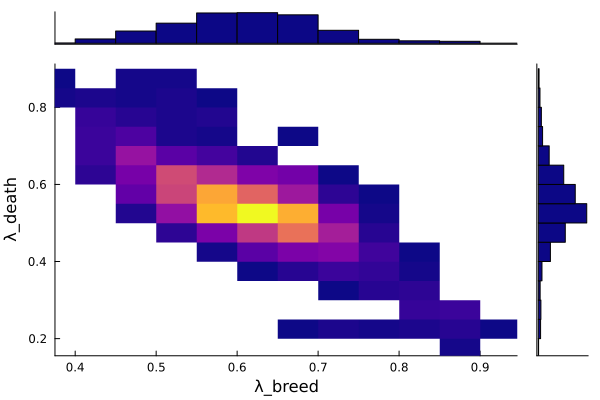

In [15]:
# Create a 2D histogram with marginal frequecies showing the distribution of values in all_λ_breed and all_λ_death
print("MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF A FLAT PRIOR")
marginalhist(
    all_λ_breed,              # x-axis data
    all_λ_death,              # y-axis data
    bins = 20,                # number of bins for each histogram
    fc = :plasma,             # fill color for the 2D histogram
    xlabel="λ_breed",         # label for the x-axis
    ylabel="λ_death"          # label for the y-axis
)


In [16]:
# Acceptance rate
acceptance_rate0 = length(all_λ_breed)/num_trial

0.01183

### C.1.2) A restricted prior

The previous ABC Monte Carlo simulation lets us have information about the region of the state space where sampled values are more accepted,
so we can restrict our parameter space according to this new information. We do it, by restricting the domain of our uniform prior distribution.

In [17]:
## Add a prior

# Initialize empty arrays to store the accepted values of λ_breed and λ_death
all_λ_breed1 = []
all_λ_death1 = []

# Set the minimum and maximum values of λ_breed and λ_death for the prior
λ_breed_min = 0.45
λ_breed_max = 0.95
λ_death_min = 0.15
λ_death_max = 0.75


0.75

In [18]:
# Set the number of trials to run and the acceptance rate for the simulated data
num_trial = 100000
ϵ = 5 #threshold 
#try with same acceptance rate and with prior 
#result: less time and better inference ------> less computational costs

# Loop through the number of trials
@showprogress for i in 1:num_trial 
    # Sample λ_breed and λ_death from a uniform distribution within the range of the prior
    l_breed = λ_breed_min + (λ_breed_max - λ_breed_min) * rand()
    l_death = λ_death_min + (λ_death_max - λ_death_min) * rand()
    
    # Generate simulated data using the current values of λ_breed and λ_death, and check if it falls within the acceptance rate
    #then we store it as a succes
    num_success, _ = gen_samples!(res_inf, prey0, pred0, l_breed, λ_interaction, l_death, max_time, p_obs, d_start, d_end, num_repetition_per_pair, obs0_prey, obs0_pred, ϵ)
    
    # If the simulated data falls within the acceptance rate, add the values of λ_breed and λ_death to the arrays
    for c in 1:num_success
        append!(all_λ_breed1, l_breed)
        append!(all_λ_death1, l_death)
    end
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF MORE RESTRICTED PRIORS

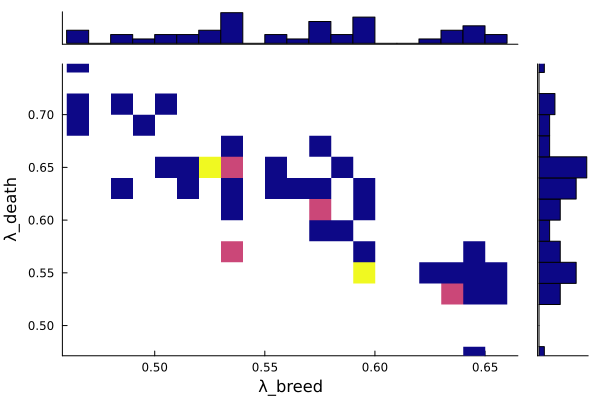

In [19]:
print("MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF MORE RESTRICTED PRIORS")

marginalhist(all_λ_breed1,
    all_λ_death1,
    bins = 20,
    fc = :plasma,
    xlabel="λ_breed",
    ylabel="λ_death"
)

In [20]:
#Acceptance rate
acceptance_rate1 = length(all_λ_breed1)/num_trial

0.00046

#### A comment on acceptance rates

Acceptance rate is quite low, the algorithm performs many rejections, resulting in slow computation and poor accuracy. This may happen for different reasons: for example, the chosen uniform prior is too different from the posterior, or the chosen threshold ($\epsilon$) is too low.
We may try different techniques in order to reduce the rejection rate and improve the inference at a lower computational cost.

### C.2) Soft margin

We can adjust the previous method by introducing a soft-margin, it works by defining a "tolerance level", which represents the maximum allowed distance between the simulated and observed data. The acceptance or rejection of a particular parameter value is then based on whether this distance is within the tolerance level, rather than a fixed threshold $\epsilon$. The simulated parameter values inside the tolerance level are then reweighted, the weights are assigned based on how closely the values match the observed data. In particular, the weight assigned to each parameter value should be proportional to the inverse of the distance between the simulated and observed data. If the tolerance level is sufficiently large, the algorithm performs no rejection. We now define an algorithm that does not reject any sample but only reweights simulated parameter values, and we use as weights
\begin{align}
w(D^*,D_{\rm true}) = e^{- \beta d(D^*,D_{\rm true})};
\end{align}
where $\beta$ is a scaling parameter.

distanza tra i valori simulati e quelli salvati

In [21]:
# Initialize empty arrays to store lambda_breed and lambda_death values with soft margin
all_λ_breed_softmargin = []
all_λ_death_softmargin = []

# Set the number of trials for soft margin and initialize the weight
num_trials_sm = 10000
weight = zeros(num_trials_sm)

# Set the value of beta and initialize a simulation object
β = 1.25 #scelto perché ci sembarava ottimale runnando piu volte
res_sm = Sim(max_time)

# Loop over the number of trials
@showprogress for iter in 1:num_trials_sm
    # Sample lambda_breed and lambda_death values using the range of soft margin
    l_breed = λ_breed_min + (λ_breed_max - λ_breed_min) * rand()
    l_death = λ_death_min + (λ_death_max - λ_death_min) * rand()
    
    # Append the lambda_breed and lambda_death values to the corresponding arrays
    append!(all_λ_breed_softmargin, l_breed)
    append!(all_λ_death_softmargin, l_death)
    
    # Generate observations and simulate the model
    lv_gen_and_obs!(res_sm, prey0, pred0, l_breed, λ_interaction, l_death, max_time, p_obs, d_start, d_end)
    obs1_prey = res_sm.obs_prey
    obs1_pred = res_sm.obs_pred
    
    # Calculate the weight for this iteration based on the distance between the generated and observed data
    weight[iter] = exp(- β * (dist(obs1_prey, obs0_prey) + dist(obs1_pred, obs0_pred)))
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [22]:
#the weights are proportional to the likelihood of the generated data given the observed data.
#The weight for each iteration is calculated as the exponential of the negative beta times the distance between the generated and observed data.
#The distance metric used in this code is the L1 distance (also called Manhattan distance),
#which measures the difference between the observed and generated data in terms of the magnitude of the difference
#in each element of the vector of simulated observations.

weight

10000-element Vector{Float64}:
 2.7894680928689246e-10
 7.1047660745491295e-9
 1.57371021068629e-11
 2.0408184531908878e-10
 3.399713971033306e-14
 7.77451385902825e-10
 1.1744099331974158e-9
 3.137797485091437e-12
 2.5946094982764667e-11
 2.601325482094023e-12
 7.30347987619557e-10
 1.5976297361005303e-12
 4.182968307488728e-12
 ⋮
 2.400917437515481e-10
 4.018609804054498e-11
 6.01057919586974e-12
 1.2818006368732858e-9
 2.6868000954616916e-10
 6.608461873854379e-10
 2.6002189446383917e-7
 3.5740210336930856e-14
 1.6665670249460302e-9
 1.0266246630950578e-15
 4.363462252943702e-9
 2.424840713182272e-9

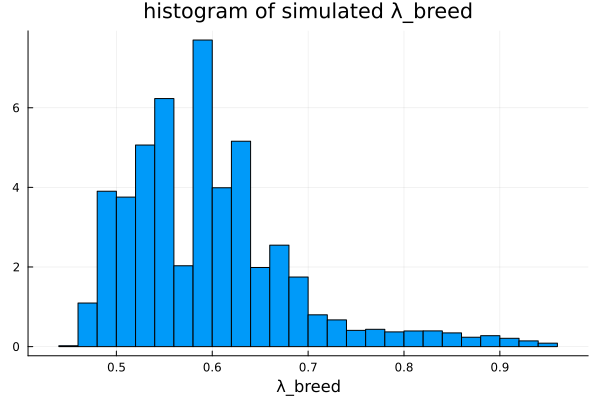

In [23]:
p1 = histogram(all_λ_breed_softmargin, bins=40, norm=true, weights=weight,normalize=true)
p2 = histogram(all_λ_death_softmargin, bins=40, norm=true, weights=weight,normalize=true)

plot(p1, legend=false,xlab=:"λ_breed", title=:"histogram of simulated λ_breed")

#When the histogram is computed with weights, each value in the input array is treated as if it appeared weight[i] times
#This means that the contribution of each data point to the histogram is proportional to its weight
#By using the weights in the histogram calculation, we are able to account for the fact that some of the generated data is more likely than others,
#and thus more informative in constraining the parameter space

#The norm=true parameter ensures that the histograms are normalized to form probability density histograms.
#The weights parameter is used to apply the importance sampling weights to the data.

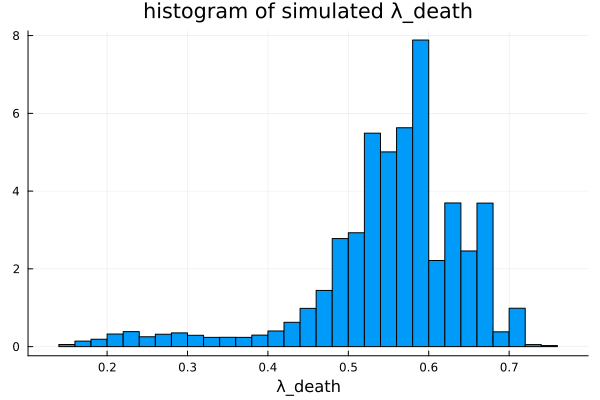

In [24]:
plot(p2, legend=false,xlab=:"λ_death", title=:"histogram of simulated λ_death")

MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF THE SOFT MARGIN METHOD

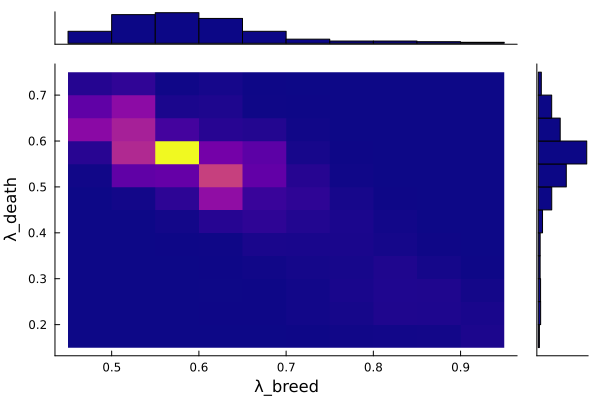

In [25]:
print("MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF THE SOFT MARGIN METHOD")
marginalhist(all_λ_breed_softmargin,
    all_λ_death_softmargin,
    bins = 20, fc = :plasma,
    xlabel="λ_breed",
    ylabel="λ_death",
    weights=weight
)

As it can be noticed, the inference is now much more precise.

### C.3) ABC-MCMC:

ABC-MCMC can be used to increase the acceptance rate with respect to rejection-based sampling, by using a smarter method to sample parameters. The result is that of an improved inference at a lower rejection rate, that is a lower computational cost.

After an initial parameter value is generated, the algorithm uses a Monte Carlo Markov Chain to iteratively update the parameter values by generating proposals from a proposal distribution. The proposal is then accepted or rejected based on its posterior probability; in particular, the probability of acceptance is based on the Metropolis criterion, i.e. the move is accepted with probability

\begin{equation*}
a = min\left(1, \frac{p(D|\theta ') p(\theta ') q(\theta^{(t)}|\theta ')}{p(D|\theta^{(t)}) p(\theta^{(t)})q(\theta'|\theta^{(t)})}\right)
\end{equation*}

where $\theta'$ is the proposed parameter, $\theta^{(t)}$ is the current parameter, $q(\theta ' | \theta^{(t)})$ is the proposal distribution. In practice, the likelihood is replace by its proxy 

\begin{equation*}
r(D, \theta ') = \frac{1}{K}\sum_{k=1}^{K} \mathbb{1}[d(D_k,D)< \epsilon]
\end{equation*}
where we set $K=1$.

By decreasing $\epsilon$ at every iteration, this algorithm is able to move the proposals from areas of low posterior probability to areas of high posterior probability.

In [26]:
# Function to generate random walk
function randomwalk(r) #o avremmo potuto utilizzare una gaussiana multivariata
    # Generate a random displacement in x and y direction within the square of linear size r
    x = r*(0.5 - rand())
    y = r*(0.5 - rand())
    # Return the tuple of x and y coordinates
    x, y
end

# Function to propose a new point for Metropolis-Hastings algorithm
function proposal(b, d, r, bmin, bmax, dmin, dmax)
    # Generate random walk displacement in b and d directions
    db, dd = randomwalk(r)
    # Calculate the new values for b and d based on the displacements
    bnew = b + db
    dnew = d + dd
    # Keep generating new points until they lie within the given bounds
    while bnew < bmin || bnew > bmax || dnew < dmin || dnew > dmax
        db, dd = randomwalk(r)
        bnew = b + db
        dnew = d + dd
    end
    # Return the tuple of proposed values for b and d
    return bnew, dnew
end

proposal (generic function with 1 method)

### C.3.1) A small step

partiamo dal punto iniziale dalla catena di markov partendo da 0.5 e 0.5 
la proposal sarà spostare i valori da 0.5 e 0.05 aggiungendo al massimo 0.02 e aggiungendo sempre nuovi trials
in seguito riduceremo sempre la distanza per ogni osservazione che viene accettata !!!!!!!!!

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


ϵ = 5.888217334801236


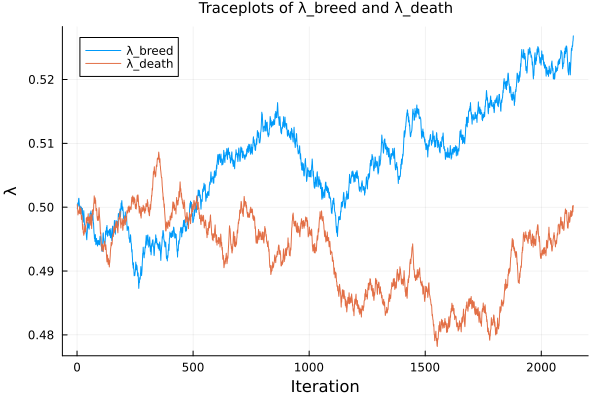

In [27]:
# Initialize empty arrays to store lambda breed and lambda death values generated using MCMC
all_λ_breed_mcmc = []
all_λ_death_mcmc = []

# Define the radius of the random walk and the value of epsilon
r = 0.002 
ϵ = 50.0

# Initialize the number of successful trials to 1, the number of repetitions per pair and the maximum values for lambda breed and lambda death
old_num_success = 1
num_repetition_per_pair = 10 
λ_breed_max = 1
λ_death_max = 1

# Initialize the old values for lambda breed and lambda death, and the number of trials to run
l_breed_old = 0.5
l_death_old = 0.5
num_trial = 10000 

# Loop over the number of trials
@showprogress for i in 1:num_trial
    # Propose a new value for lambda breed and lambda death using the previous values and the random walk
    l_breed, l_death = proposal(l_breed_old, l_death_old, r, 0.0, λ_breed_max, 0.0, λ_death_max)
    
    # Generate samples using the proposed values and the model, and calculate the number of successful trials
    num_success, _ = gen_samples!(res_inf, prey0, pred0, l_breed, λ_interaction, l_death, max_time, p_obs, d_start, d_end, num_repetition_per_pair, obs0_prey, obs0_pred, ϵ)
    
    # Use the Metropolis-Hasting algorithm to decide whether to accept the proposed values
    if(rand() < num_success/old_num_success)
        # If the proposed values are accepted, append the new lambda breed and lambda death values to the corresponding arrays
        append!(all_λ_breed_mcmc, l_breed)
        append!(all_λ_death_mcmc, l_death)
        # Update the old values for lambda breed and lambda death, the number of successful trials, and epsilon
        old_num_success = num_success
        l_breed_old = l_breed
        l_death_old = l_death
        ϵ *= 0.999
    end
end

# Display the final value of epsilon and plot the lambda breed and lambda death values generated using MCMC
@show ϵ
plot4 = plot(all_λ_breed_mcmc, label="λ_breed")
plot4 = plot!(all_λ_death_mcmc, label="λ_death")
plot4 = plot!(xlabel="Iteration", ylabel="λ", legend=:best, title =:"Traceplots of λ_breed and λ_death",titlefont=font(10))

#here we can observe the traceplots of λ_breed and λ_death respectively
#rappresentano i valori accettati dalla catena nel corso del tempo tra le varie iterazioni
#la catena esplora molto poco e  non va bene ha un bad mixing

MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF THE ABC-MCMC METHOD

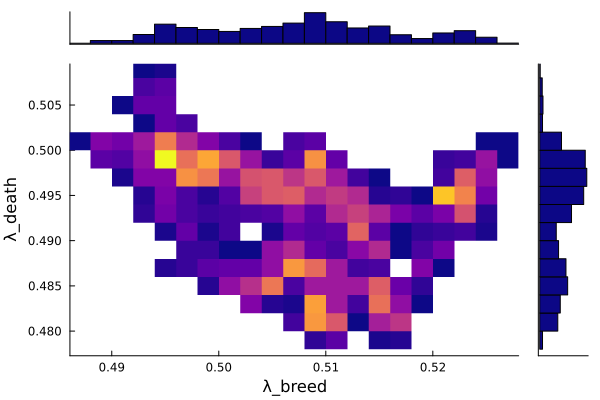

In [28]:
print("MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF THE ABC-MCMC METHOD")
marginalhist(all_λ_breed_mcmc,
    all_λ_death_mcmc,
    bins = 20,
    fc = :plasma,
    xlabel="λ_breed",
    ylabel="λ_death"    
)

# MCMC Heat Map of λ_breed and λ_death si puom vedere anche qua il bad mixing, perché non cè stata una buona esplorazione

In [29]:
#Acceptance rate
acceptance_rate_mcmc = length(all_λ_breed_mcmc)/num_trial

0.2138

We can notice that, although the acceptance rate is much higher than in the ABC rejection-based case, the inference is quite bad. It seems that the proposed parameters are stuck into the wrong set of values for too many iterations. \
This happens because  the variance of the proposal distribution is very small, implying that many proposed moves will be accepted, but they represent very small movements, hence the chain is not mixing well, and the parameter space is not explored much by the chain. 

#### Some diagnostics

This can be proven also by looking at the Autocorrelation Function. The ACF measures the correlation between consecutive MCMC sampled values. A high ACF indicates that the chain is not mixing well and that the samples are not independent. One should aim for a low ACF or a rapid decay in the ACF.
With $r=0.002$, autocorrelation values remain high even after many iterations and decrease at a low rate.

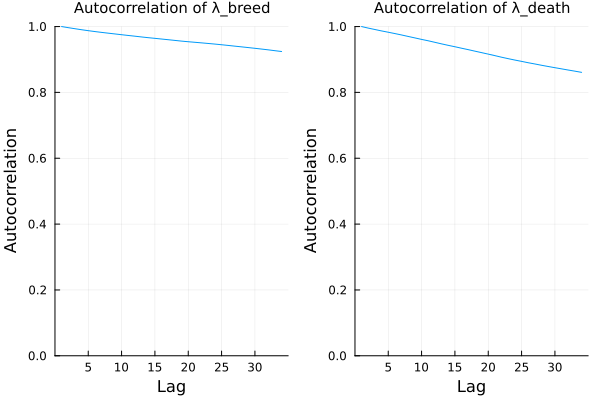

In [30]:
all_λ_breed_mcmc_abs = convert(AbstractVector{Float64}, all_λ_breed_mcmc)
all_λ_death_mcmc_abs = convert(AbstractVector{Float64}, all_λ_death_mcmc)
autocor_b = autocor(all_λ_breed_mcmc_abs, demean=true)
autocor_d = autocor(all_λ_death_mcmc_abs, demean=true)
plot_b = plot(autocor_b, label="",ylims=(0,1))
plot_b = plot!(xlabel="Lag", ylabel="Autocorrelation",title=:"Autocorrelation of λ_breed",titlefont=font(10))
plot_d = plot(autocor_d, label="",ylims=(0,1))
plot_d = plot!(xlabel="Lag", ylabel="Autocorrelation", title=:"Autocorrelation of λ_death",titlefont=font(10))
plot(plot_b,plot_d)

#misura la correlazione che c'è tra i valori campionati tra una simulazione e l'altra
#con un passo così basso la simulazione sarà molto alta

### C.3.2) A larger step + burn-in

To fix this, we try by increasing the step to $r=0.15$. Indeed, by increasing the step we reduce the correlation of the Markov Chain, allowing it to explore a larger area of the parameter space and getting more information per iteration.

Moreover, this translates into a shorter time needed to achieve stationarity of the estimates, which allows us to set a burn-in period. 
It is possible to set a burn-in period where the algorithm has not yet reached stationarity and has not yet started sampling from the target distribution. In this case, the Markov Chain is run for a specific number of iterations but the output of the chain is discarded. Discarding the burn-in period from our sample of $\theta^{(t)}$ allows to obtain a better approximation of $p(\theta|D)$.

proviamo con un passo molto piu alto
ma qua molte proposal vengono accettate

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


ϵ = 4.859119400482309


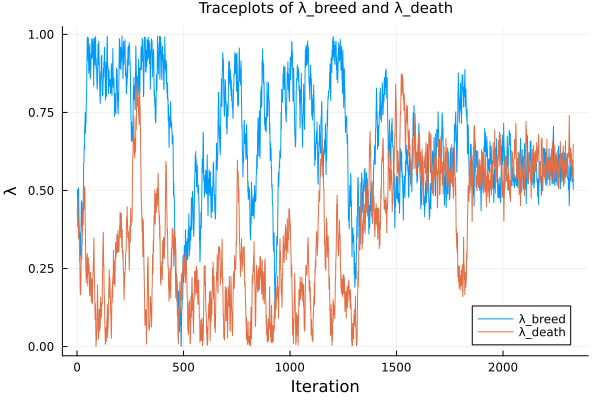

In [31]:
function gen_sample!(res, prey0, pred0, λ_breed, λ_interaction, λ_death, max_time, p_obs, d_start, d_end, obs0_prey, obs0_pred, ϵ)
    count = 0
    # Generate new observation and store in `res`
    lv_gen_and_obs!(res, prey0, pred0, λ_breed, λ_interaction, λ_death, max_time, p_obs, d_start, d_end)
    # Extract new observations of prey and predator from `res`
    obs1_prey = res.obs_prey
    obs1_pred = res.obs_pred
    d = 0.0
    # Check if the difference between new and old observations is less than the threshold ϵ
    if dist(obs1_prey, obs0_prey) <= ϵ && dist(obs1_pred, obs0_pred) <= ϵ
        count += 1
        # Compute distance between the two observations
        d = dist(obs1_prey, obs0_prey) + dist(obs1_pred, obs0_pred)
    end
    # end
    # Return the count and the distance
    return count, d
end

# Create empty arrays to store MCMC samples
all_λ_breed_mcmc1 = []
all_λ_death_mcmc1 = []

# Set parameters for MCMC sampling
res_inf=Sim(max_time)
r = 0.15
ϵ = 50.0
old_num_success = 1
num_repetition_per_pair = 10
distances = zeros(Float64, num_repetition_per_pair)'
λ_breed_max = 1
λ_death_max = 1
l_breed_old = 0.5
l_death_old = 0.5
num_trial = 10000

# set a flag to control when to start saving the values of lambda breed and lambda death (after burn-in)
flag = 0

# set a burn-in value
burn_in = 0

# Run the MCMC sampling for `num_trial` iterations
@showprogress for i in 1:num_trial
    # Propose a new value for λ_breed and λ_death using the `proposal` function
    l_breed, l_death = proposal(l_breed_old, l_death_old, r, 0.0, λ_breed_max, 0.0, λ_death_max)
    dis = zeros(Float64, num_repetition_per_pair)
    num_success = 0
    # Repeat the generation and observation process `num_repetition_per_pair` times
    for i=1:num_repetition_per_pair
        n, d = gen_sample!(res_inf, prey0, pred0, l_breed, λ_interaction, l_death, max_time, p_obs, d_start, d_end, obs0_prey, obs0_pred, ϵ)
        dis[i] = d
        num_success+=n
    end
    # Use Metropolis-Hastings to accept or reject the new proposal
    if rand() < num_success/old_num_success
        # If the flag is greater than or equal to the burn-in value, record the values of lambda breed and lambda death
        if(flag>=burn_in)
            append!(all_λ_breed_mcmc1, l_breed)
            append!(all_λ_death_mcmc1, l_death)
        end

        # update the number of successful iterations, the values of lambda breed and lambda death and record distances
        old_num_success = num_success
        l_breed_old = l_breed
        l_death_old = l_death
        distances = vcat(distances, dis')

        # decrease the value of the tolerance
        ϵ *= 0.999

        # increment the flag
        flag+=1
    end
end

# Print the final value of ϵ
@show ϵ

# Plot the MCMC samples for λ_breed and λ_death
plot5 = plot(all_λ_breed_mcmc1, label="λ_breed")
plot5 = plot!(all_λ_death_mcmc1, label="λ_death")
plot5 = plot!(xlabel="Iteration", ylabel="λ", legend=:best,title=:"Traceplots of λ_breed and λ_death",titlefont=font(10))

The traceplot above shows a good exploration of the parameter space; we will later introduce a burn-in of 1000 iterations.

MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF THE ABC-MCMC METHOD WITHOUT BURN-IN

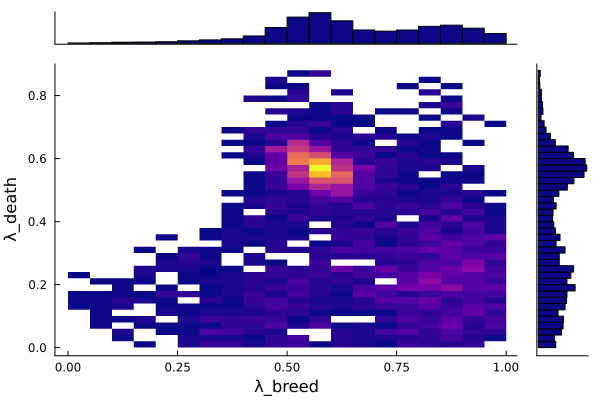

In [32]:
print("MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF THE ABC-MCMC METHOD WITHOUT BURN-IN")
marginalhist(all_λ_breed_mcmc1,
    all_λ_death_mcmc1,
    fc=:plasma,
    bins=40,
    xlabel="λ_breed",
    ylabel="λ_death"   
)

In [33]:
#Acceptance rate
acceptance_rate1 = (length(all_λ_breed_mcmc1)+burn_in)/num_trial

0.233

The acceptance rate is better than the one in the previous case.

#### Some diagnostics

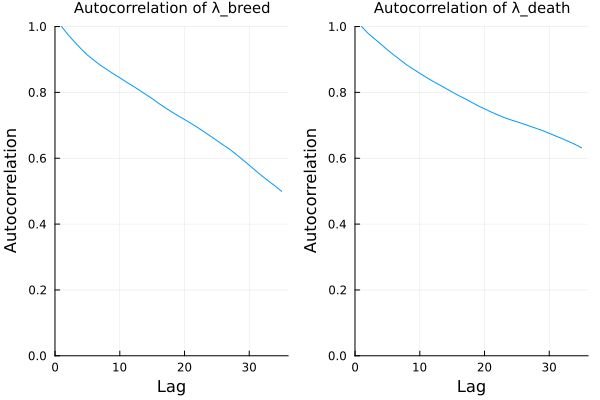

In [34]:
all_λ_breed_mcmc1_abs = convert(AbstractVector{Float64}, all_λ_breed_mcmc1)
all_λ_death_mcmc1_abs = convert(AbstractVector{Float64}, all_λ_death_mcmc1)
autocor_b1 = autocor(all_λ_breed_mcmc1_abs, demean=true)
autocor_d1 = autocor(all_λ_death_mcmc1_abs, demean=true)
plot_b1 = plot(autocor_b1, label="",ylims=(0,1))
plot_b1 = plot!(xlabel="Lag", ylabel="Autocorrelation",title=:"Autocorrelation of λ_breed",titlefont=font(10))
plot_d1 = plot(autocor_d1, label="",ylims=(0,1))
plot_d1 = plot!(xlabel="Lag", ylabel="Autocorrelation",title=:"Autocorrelation of λ_death",titlefont=font(10))
plot(plot_b1,plot_d1)

The ACFs decrease more rapidly than the previous case, but this decay is still slow. This means that the iteration at a time $t$ is highly correlated with the iteration at time $t-1$. Therefore, the $\textit{effective sample size}$ is low.

In [35]:
gewekediag(all_λ_breed_mcmc1_abs,first=0.1,last=0.5)
#va bene perché il z score deve essere vicino alla media della gaussiana

(zscore = 3.017469341656314, pvalue = 0.002548948230990356)

Geweke's test compares the means of two non-overlapping segments of the chain to detect any changes in the mean value of the chain over time. It assumes that if the chain has converged to the target distribution, then the mean value should be consistent across the entire chain.
With Geweke's test, there is no evidence of non-convergence since the Z-score statistics of the test is not an extreme value of the standard normal.

We now plot the distances between the simulated and known observations during the iterations of the ABC-MCMC, when simulated values are accepted. The light blue line represents the threshold above which we reject the proposals.

In [36]:
accepted_distances=zeros(Float64,1,2)
#it is the vector of the distances between the observed prey and predator populations and the corresponding simulated populations at each iteration.
#If the distance is less than or equal to the specified tolerance ϵ,
#the repetition is counted as a success and stored in the matrix, and the distance value is added to the distances vector.
v = [100*(0.999)^i for i=1:length(all_λ_breed_mcmc1)]

for i in 1:size(distances,1)
    for j in 1:size(distances,2)
        if distances[i,j]!=0
            aux=[i,distances[i,j]]
            accepted_distances=vcat(accepted_distances,aux')
        end
    end
end
accepted_distances

plot7 = plot(v, legend = false,linewidth=4.0)
plot7 =plot!(accepted_distances[2:end,1],accepted_distances[2:end,2],seriestype=:scatter, markersize=2, markercolor=:blue)
plot(plot7,title=:"Distances between the simulated and known observations",titlefont=font(10))

#all'inizio l'accettazione è molto alta e prendiamo anche i dati non veri
#utilizziamo il burn in per bruciare le osservazioni iniziali

#### Discarding burn-in

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


ϵ = 4.849406020800745


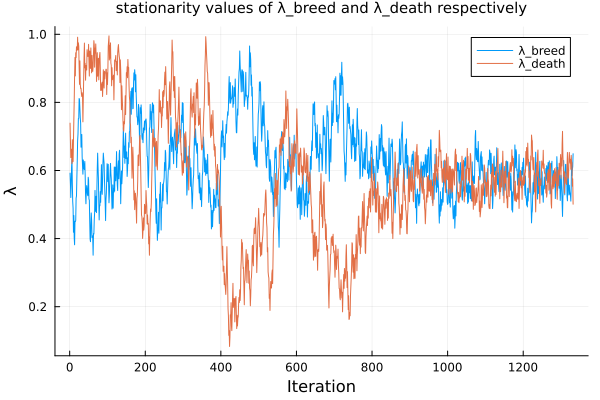

In [37]:
# PLOT AFTER BURN-IN 

# Create empty arrays to store MCMC samples
all_λ_breed_mcmc1 = []
all_λ_death_mcmc1 = []

# Set parameters for MCMC sampling
res_inf=Sim(max_time)
r = 0.15
ϵ = 50.0
old_num_success = 1
num_repetition_per_pair = 10
distances = zeros(Float64, num_repetition_per_pair)'
λ_breed_max = 1
λ_death_max = 1
l_breed_old = 0.5
l_death_old = 0.5
num_trial = 10000

# set a flag to control when to start saving the values of lambda breed and lambda death (after burn-in)
flag=0

# set a burn-in value
burn_in = 1000

# Run the MCMC sampling for `num_trial` iterations
@showprogress for i in 1:num_trial
    # Propose a new value for λ_breed and λ_death using the `proposal` function
    l_breed, l_death = proposal(l_breed_old, l_death_old, r, 0.0, λ_breed_max, 0.0, λ_death_max)
    dis = zeros(Float64, num_repetition_per_pair)
    num_success = 0
    # Repeat the generation and observation process `num_repetition_per_pair` times
    for i=1:num_repetition_per_pair
        n, d = gen_sample!(res_inf, prey0, pred0, l_breed, λ_interaction, l_death, max_time, p_obs, d_start, d_end, obs0_prey, obs0_pred, ϵ)
        dis[i] = d
        num_success+=n
    end
    # Use Metropolis-Hastings to accept or reject the new proposal
    if rand() < num_success/old_num_success
        # If the flag is greater than or equal to the burn-in value, record the values of lambda breed and lambda death
        if(flag>=burn_in)
            append!(all_λ_breed_mcmc1, l_breed)
            append!(all_λ_death_mcmc1, l_death)
        end

        # update the number of successful iterations, the values of lambda breed and lambda death and record distances
        old_num_success = num_success
        l_breed_old = l_breed
        l_death_old = l_death
        distances = vcat(distances, dis')

        # decrease the value of the tolerance
        ϵ *= 0.999

        # increment the flag
        flag+=1
    end
end

# Print the final value of ϵ
@show ϵ

# Plot the MCMC samples for λ_breed and λ_death
plot5 = plot(all_λ_breed_mcmc1, label="λ_breed")
plot5 = plot!(all_λ_death_mcmc1, label="λ_death")
plot5 = plot!(xlabel="Iteration", ylabel="λ", legend=:best,title=:"stationarity values of λ_breed and λ_death respectively",titlefont=font(10))

MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF THE ABC-MCMC METHOD WITH BURN-IN

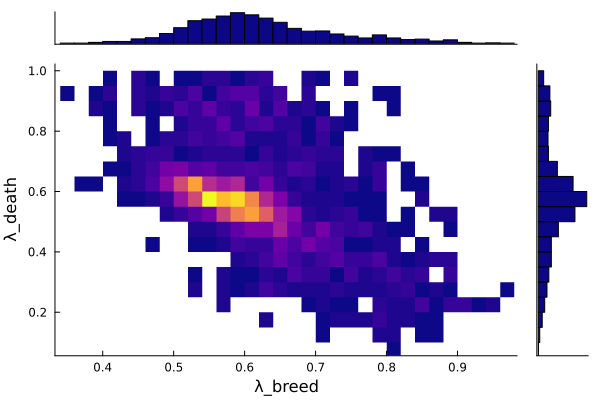

In [38]:
print("MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF THE ABC-MCMC METHOD WITH BURN-IN")
marginalhist(all_λ_breed_mcmc1,
    all_λ_death_mcmc1,
    fc=:plasma,
    bins=40,
    xlabel="λ_breed",
    ylabel="λ_death"   
)

### C.3.3) An even larger step

We, finally, try the same method with an even higher step ($r=0.7$) in order to discuss the differences with the previous case. We can notice that much of the parameter space is explored, but the precision of the inference is decreased.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


ϵ = 5.578535430069411


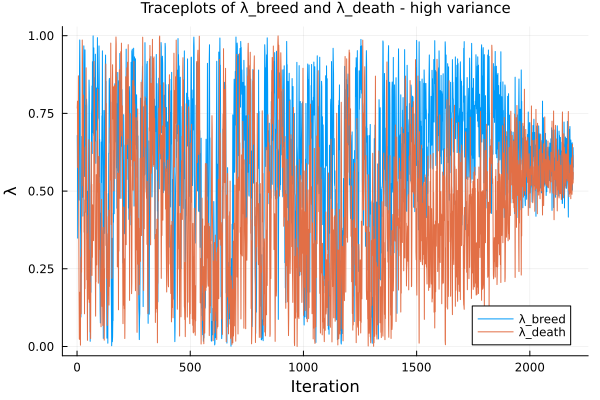

In [39]:
# initialize empty vectors to store parameter values for each iteration
all_λ_breed_mcmc2 = []
all_λ_death_mcmc2 = []

# Create a simulation object to hold simulation data
res_inf = Sim(max_time)

# set initial values for parameters, tuning parameter, convergence threshold, and number of trials
r = 0.7
ϵ = 50.0
old_num_success = 1
num_repetition_per_pair = 10
λ_breed_max = 1 #max value of λ_breed
λ_death_max = 1
l_breed_old = 0.5 
l_death_old = 0.5
num_trial = 10000

# loop over specified number of trials
@showprogress for i in 1:num_trial
    # propose a new value for parameters
    l_breed, l_death = proposal(l_breed_old, l_death_old, r, 0.0, λ_breed_max, 0.0, λ_death_max)
    
    # generate samples and calculate number of successful simulations
    num_success, _ = gen_samples!(res_inf, prey0, pred0, l_breed, λ_interaction, l_death, max_time, p_obs, d_start, d_end, num_repetition_per_pair, obs0_prey, obs0_pred, ϵ)
    
    # perform Metropolis-Hastings step and update variables
    if(rand() < num_success/old_num_success)
        append!(all_λ_breed_mcmc2, l_breed)
        append!(all_λ_death_mcmc2, l_death)
        old_num_success = num_success
        l_breed_old = l_breed
        l_death_old = l_death
        ϵ *= 0.999
    end
end

# print final convergence threshold value
@show ϵ

# plot parameter values over iterations

plot6 = plot(all_λ_breed_mcmc2, label="λ_breed")
plot6 = plot!(all_λ_death_mcmc2, label="λ_death")
plot6 = plot!(xlabel="Iteration", ylabel="λ", legend=:best,title=:"Traceplots of λ_breed and λ_death - high variance",titlefont=font(10))

#mix molto buono ma varienza molto alta
#dobbiamo stare attenti alla nostra convergenza della markov chain

MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF THE ABC-MCMC METHOD INCREASING r

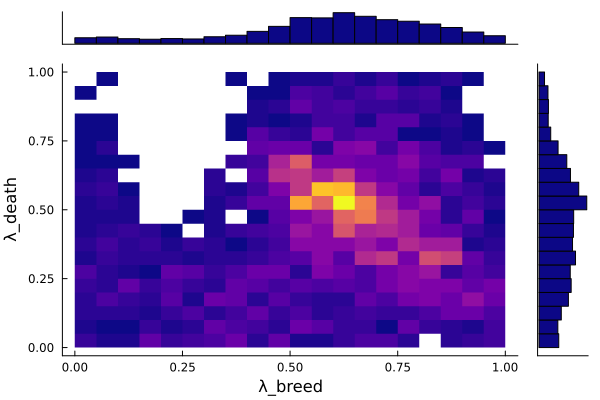

In [40]:
print("MARGINAL AND JOINT DISTRIBUTIONS OF INFERENCES THROUGH APPLICATION OF THE ABC-MCMC METHOD INCREASING r")
marginalhist(all_λ_breed_mcmc2,
    all_λ_death_mcmc2,
    bins = 20,
    fc = :plasma,
    xlabel="λ_breed",
    ylabel="λ_death"
)

Traceplots show a good mixing and the parameter space is explored well. However the heatmap shows less precision than in the previous case.

In [41]:
#Acceptance rate
acceptance_rate2 = length(all_λ_breed_mcmc2)/num_trial

0.2192

The acceptance rate with a random walk proposal distribution of linear size $r=0.7$ is almost equivalent to the one of the case of same proposal distribution with step $r=0.2$.

#### Some diagnostics

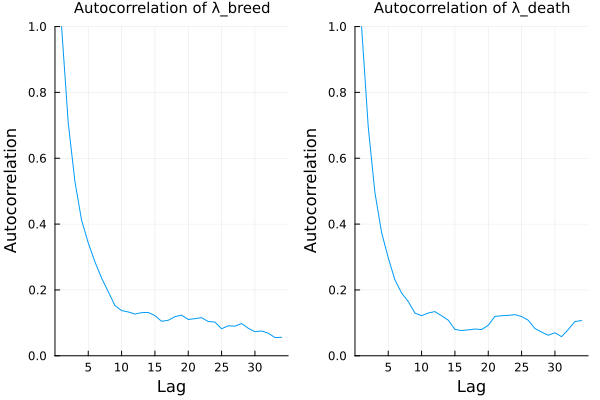

In [42]:
all_λ_breed_mcmc2_abs = convert(AbstractVector{Float64}, all_λ_breed_mcmc2)
all_λ_death_mcmc2_abs = convert(AbstractVector{Float64}, all_λ_death_mcmc2)
autocor_b2 = autocor(all_λ_breed_mcmc2_abs, demean=true)
autocor_d2 = autocor(all_λ_death_mcmc2_abs, demean=true)
plot_b2 = plot(autocor_b2, label="",ylims=(0,1))
plot_b2 = plot!(xlabel="Lag", ylabel="Autocorrelation",title=:"Autocorrelation of λ_breed",titlefont=font(10))
plot_d2 = plot(autocor_d2, label="",ylims=(0,1))
plot_d2 = plot!(xlabel="Lag", ylabel="Autocorrelation",title=:"Autocorrelation of λ_death",titlefont=font(10))
plot(plot_b2,plot_d2)

The autocorrelation functions decay very rapidly, this means that the correlation between iterated observations is very low also after a few iterations, leading to a higher ESS.

In [43]:
gewekediag(all_λ_breed_mcmc2_abs,first=0.1,last=0.5)

#possiamo dire che c'è convergenza

(zscore = -0.6461669220130817, pvalue = 0.5181712590087189)

As the previous case, there is no evidence of non-convergence since the Z-score statistics of the test is not an extreme value of the standard normal.

## D) Approximate Bayesian Computation Monte Carlo method to infer 3 probabilities

If one has to infer all the three parameters, the $\textit{typical set}$ containing the true values will be a much smaller portion of the state space. Hence, the probability of acceptance using the ABC rejection-based or ABC-MCMC will be much smaller. 

Imagine sampling $\theta^{(t)}$ randomly from a uniform prior distribution on the entire $3$-dimensional unit cube (as in the ABC rejection case), or from the random-walk proposal distribution (as in the ABC-MCMC): since the typical set is a small region of the parameter space, the sampled $\theta^{(t)}$ will be rejected very often. The direct consequence is that we must generate a lot of trials for the parameters to have adequate inference, hence the cost of computation increases.

To proceed in a more convenient way, we could use a $\textit{Sequential MC}$ method. \
This method exploits the benefit of sampling with a Markov Chain as in the MCMC, but the sampling is done from a a sequence of approximate posterior distributions, which is improved iteratively.




In the first iteration, $\theta^*$ is sampled from the prior distribution. In $t>2$, from the last iteration parameters $\{\theta^{(i)}_{t-1}\}$, $\theta^*$ is sampled using the weights $\{w^{(i)}_{t-1}\}$. \
Then a proposal $\theta^{**}$ is generated by perturbing $\theta^*$ using $q_t(\theta|\theta^*)$. $\theta^{**}$ is then used to simulate a new set of data, and, if the data have a likelihood that well approximates the observed one (i.e. the distance between the simulated and observed data, or between a set of summary statistics, is less than $\epsilon$), $\theta^{**}$ is accepted and it is used to populate a vector $\{\theta^{(i)}_{t}\}$. \
Finally, we update the corresponding weights with

\begin{align*}
w^{(i)}_t = \frac{p(\theta_t^{(i)})}{\sum_{j=1}^M w_{t-1}^{(j)}q_t(\theta^{(i)}_t|\theta_{t-1}^{(j)})}
\end{align*}
The idea behind the weights is the same as the importance sampling weights.

The MCMC algorithm allows the particles to explore the posterior distribution more efficiently, and the resulting posterior distribution is a better approximation of the true one.\
This process is repeated for a number of iterations, with the threshold value for accepting particles gradually decreased at each iteration, until the desired level of approximation of the true posterior distribution is achieved. \
In summary, SMC allows us to sample in a smarter way, reducing the rejection.

In the following we propose an algorithm for performing a SMC for inferring the three probabilities governing our model. \
In order to make the most out of the SMC method we need to find a good prior distribution. By restricting the value of some parameters, we can significantly decrease the number of trials needed for good inference, which is still much needed since the typical set is very small. \
By observing the data on the new number of prey and predators, one can reasonably assume that $\lambda_{interaction}$ should be quite low, as it doesn't happen that the number of predators increase excessively with an increase in preys. 
Hence, we first want to show that high values of $\lambda_{interaction}$ should be excluded. We do it by showing that for $\lambda_{interaction}>0.05$ the acceptance rate is way too low.\
Therefore, we set $\lambda_{interaction} \in [0,0.05]$ and we leave $\lambda_{breed}, \lambda_{death} \in [0,1]$. In this way, with just 1000 trials the algorithm succeeds in performing a fairly good inference. Still, a better inference could be achieved by increasing the number of trials.

In [44]:
function randomwalk_sequential(r1,r2)
    x = r1*(0.5 - rand())
    y = r2*(0.5 - rand())
    z = r1*(0.5 - rand())
    x,y,z
end

function proposal_sequential(b, i, d, r1, r2, bmin, bmax, imin, imax, dmin, dmax)
    # This function proposes a new set of parameter values for the model using a sequential Monte Carlo method.
    # It generates a new set of parameter values by randomly walking from the old parameter values, subject to certain constraints.
    # Input:
    # b, i, d: Old parameter values for birth rate, interaction rate, and death rate, respectively
    # r1, r2: Step size in x and z dimensions, and y dimension, respectively, for the random walk
    # bmin, bmax, imin, imax, dmin, dmax: Minimum and maximum allowed parameter values for birth rate, interaction rate, and death rate, respectively
    # Output:
    # Three values, representing the proposed new parameter values for birth rate, interaction rate, and death rate, respectively
    
    bnew = b # initialize new birth rate to old value
    inew = i # initialize new interaction rate to old value
    dnew = d # initialize new death rate to old value
    flag = 0 # initialize flag variable to 0
    
    # Loop until flag is set to 1 (i.e., until a valid set of parameter values is generated)
    while flag == 0
        db, di, dd = randomwalk_sequential(r1,r2) # generate random walk in three dimensions
        bnew = b + db # propose new birth rate value by adding step in x dimension
        inew = i + di # propose new interaction rate value by adding step in y dimension
        dnew = d + dd # propose new death rate value by adding step in z dimension
        flag = 1 # assume new parameter values are valid unless proven otherwise
        if bnew < bmin || bnew > bmax || inew < imin || inew > imax || dnew < dmin || dnew > dmax
            flag = 0 # if any of the proposed parameter values are outside the allowed range, set flag to 0 to indicate invalid parameter values
        end
    end
    
    return bnew, inew, dnew # return proposed new parameter values
end

proposal_sequential (generic function with 1 method)

In [45]:
function reweight(w0, θpop, θi, θsize, radius1, radius2)
    # `reweight` function takes in a set of weights `w0`, a population of parameter sets `θpop`, 
    # the current parameter set `θi`, the size of the population `θsize`, and two radii values `radius1` and `radius2`.
    
    s = 0 # Initialize the sum of weights

    # Iterate over all parameter sets in the population
    for i in 1:θsize
        # Check if the difference between each parameter value of the current parameter set `θi`
        # and the corresponding parameter value of the parameter set in the population `θpop[i]` 
        # is less than the radius values
        if ((abs(θpop[i, 1] - θi[1]) < radius1/2) && (abs(θpop[i, 2] - θi[2]) < radius2/2) && (abs(θpop[i, 3] - θi[3]) < radius1/2))
            s += w0[i] # Add the weight of the parameter set in the population to the sum of weights
        end
    end

    # Return the reciprocal of the sum of weights
    1.0 / s
end


reweight (generic function with 1 method)

In [46]:
# Create a simulation object with the maximum time
res2 = Sim(max_time)

# Set the observation probability
p_obs = 0.9

# Run the Lotka-Volterra model with the specified parameters and observation settings
lv_gen_and_obs!(res2, prey0, pred0, λ_breed, λ_interaction, λ_death, max_time, p_obs, d_start, d_end)

# Extract the prey and predator observations from the simulation object
obs0_prey_smc = res2.obs_prey
obs0_pred_smc = res2.obs_pred

100-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [47]:
# Set the value of the tolerance parameter
ϵ = 10

# Set the probability of observing a prey-predator interaction
p_obs = 0.9

# Set the population parameters and initialize the population
θsize = 100000
bmin = 0.0
bmax = 1.0
imin = 0.05
imax = 1.0
dmin = 0.0
dmax = 1.0

# Create a variable to sum the number of accepted iterations
acceptances = 0

# Create a simulation object to hold simulation data
res_inf = Sim(max_time)

# set the number of repetitions per pair of predator and prey
num_repetition_per_pair = 10 

# Create an array to store the population of parameter values
θpop = zeros(θsize, 3)

# Initialize the values of the parameters for each individual in the population
for i in 1:θsize
    # Set the initial value of I for this individual
    θpop[i, 2] = imin + rand() * (imax - imin)
    
    # Set the initial value of B for this individual
    θpop[i, 1] = bmin + rand() * (bmax - bmin)
    
    # Set the initial value of D for this individual
    θpop[i, 3] = dmin + rand() * (dmax - dmin)
end

# Evaluate the acceptance rate for each individual in the population
for i in 1:θsize
    # Get the parameter values for this individual
    θnew = θpop[i, 1:3]
    
    # Generate samples and count the number of successes
    num_success, _ = gen_samples!(res_inf, prey0, pred0, θnew[1], θnew[2], θnew[3], max_time, p_obs, d_start, d_end, num_repetition_per_pair, obs0_prey_smc, obs0_pred_smc, ϵ)
    
    # Sum the number of successes to the "acceptances" value
    acceptances+=num_success
end

# Compute the acceptance rate of the population
acceptance_rate = acceptances / θsize

# Print the acceptance rate
acceptance_rate


6.0e-5

For $\lambda_{interaction}>0.05$ and with a threshold $\epsilon=10$ the acceptance rate is very close to 0, so we can conclude that the set of accepted instances is negligible.

In [48]:
# Set the value of ϵ
ϵ = 10

# Create a simulation object to hold simulation data
res_inf = Sim(max_time)

# Population parameters and initialization
θsize = 2000
bmin = 0.0
bmax = 1.0
imin = 0.0
imax = 0.05
dmin = 0.0
dmax = 1.0
θpop = zeros(θsize, 3)
θindex=[i for i in 1:θsize]

# Generate initial population
# Assign random values to θpop[i,2] (immigration rate) and θpop[i,3] (predation rate) for each i in 1:θsize
# Assign a random value to θpop[i,1] (birth rate) for each i in 1:θsize
[θpop[i,2] = imin + rand() * (imax - imin) for i in 1:θsize]
[θpop[i,1] = rand() for i in 1:θsize]
[θpop[i,3] = rand() for i in 1:θsize]

# Set up initial weights
wθ = ones(θsize) / θsize

# Set up old weights and old population
wθ_old = wθ / sum(wθ)
θpop_old = θpop

# Set up other variables for algorithm
old_num_success = 1
num_repetition_per_pair = 1
radius1 = 0.1
radius2 = 0.0025
num_trial = 1000

#Set a variable that counts number of accepted values
acceptances_smc = 0

# Perform the genetic algorithm
@showprogress for i in 1:num_trial
    # Select a random individual from the previous population
    for j in 1:θsize
        ind = sample(θindex, Weights(wθ_old))
        
        # Propose a new individual
        θnew = proposal_sequential(θpop_old[ind,1], θpop_old[ind,2], θpop_old[ind,3], radius1, radius2, bmin, bmax, imin, imax, dmin, dmax)
        
        # Evaluate the performance of the new individual
        num_success, _ = gen_samples!(res_inf, prey0, pred0, θnew[1], θnew[2], θnew[3], max_time, p_obs, d_start, d_end, num_repetition_per_pair, obs0_prey_smc, obs0_pred_smc, ϵ)
        
        # Update the population based on the performance of the new individual
        if rand() < num_success / old_num_success
            θpop[ind,1] = θnew[1]
            θpop[ind,2] = θnew[2]
            θpop[ind,3] = θnew[3]
            wθ[ind] = reweight(wθ_old, θpop_old, θpop[ind,1:3], θsize, radius1, radius2)
            old_num_success = num_success
            acceptances_smc+=num_success
        end
    end
    
    # Decrease the value of ϵ
    ϵ *= 0.999
    
    # Update the weights and population
    wθ_old = wθ / sum(wθ)
    θpop_old = θpop
end

# Print the final value of ϵ
print("The final value of ϵ is ", ϵ)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:37


The final value of ϵ is 3.6769542477096318

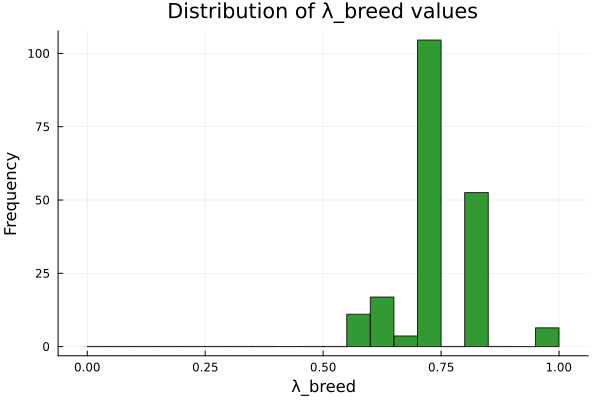

In [49]:
histogram(θpop[:,1], weights=wθ,
          bins=20,
          xlabel="λ_breed", 
          ylabel="Frequency",
          title="Distribution of λ_breed values",
          label="",
          color=:green,
          alpha=0.8,
          edgecolor=:black,
          lw=1,
          legend=:topright)

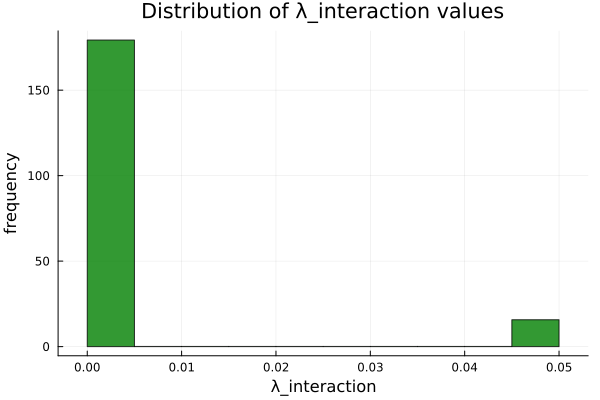

In [50]:
histogram(θpop[:,2], weights=wθ,
          bins=20,
          xlabel="λ_interaction", 
          ylabel="frequency",
          title="Distribution of λ_interaction values",
          label="",
          color=:green,
          alpha=0.8,
          edgecolor=:black,
          lw=1,
          legend=:topright)

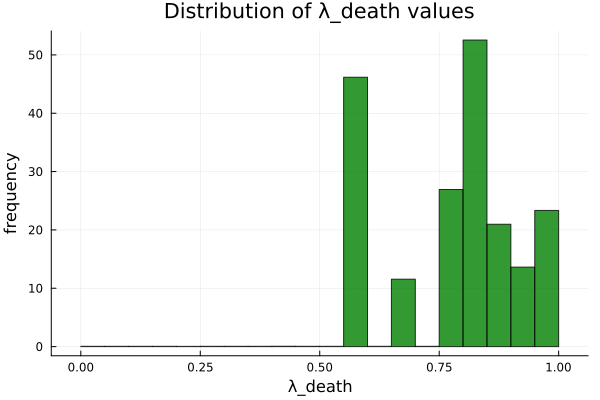

In [51]:
histogram(θpop[:,3], weights=wθ,
          bins=20,
          xlabel="λ_death", 
          ylabel="frequency",
          title="Distribution of λ_death values",
          label="",
          color=:green,
          alpha=0.8,
          edgecolor=:black,
          lw=1,
          legend=:topright)

MARGINAL AND JOINT DISTRIBUTIONS OF λ_BREED AND λ_DEATH THROUGH APPLICATION OF THE SEQUENTIAL MONTE CARLO METHOD

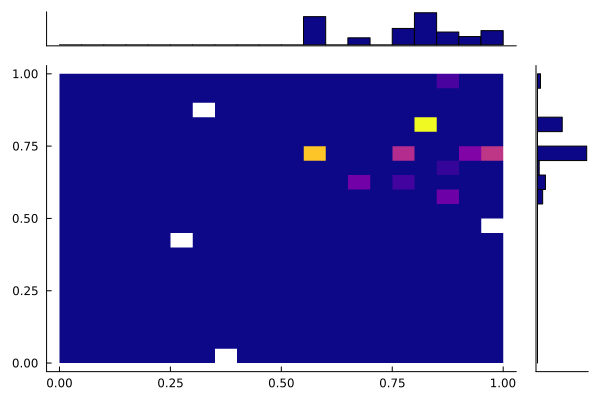

In [55]:
print("MARGINAL AND JOINT DISTRIBUTIONS OF λ_BREED AND λ_DEATH THROUGH APPLICATION OF THE SEQUENTIAL MONTE CARLO METHOD")
marginalhist(θpop[:,3],θpop[:,1],fc=:plasma,bins=20,weights=wθ)

In [56]:
#Acceptance rate
acceptance_rate_smc= acceptances_smc / (θsize*num_trial)

0.2896675